In [1]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from open_ephys.analysis import Session
import datetime
from aind_ephys_rig_qc.temporal_alignment import search_harp_line
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from utils.plot_utils import combine_pdf_big

from open_ephys.analysis import Session
from pathlib import Path
import glob

import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from hdmf_zarr.nwb import NWBZarrIO
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
import pandas as pd
import pickle
import scipy.stats as stats
from joblib import Parallel, delayed
from multiprocessing import Pool
from functools import partial
import time
import spikeinterface as si
import shutil
import seaborn as sns
%matplotlib inline

In [2]:
# loop through all sessions
# count number of units pass qc and opto qc
# check if exist in longer than 100 sessions 
# check if exist in pre/post stimulation
# check if exist in anti-dromic stimulation
all_sessions = []
all_units = []
all_qc_pass_units = [] # default qc pass
all_real_units = [] # not noise, not artifact
all_tagged_units = []
in_behavior = []
opto_tagging_pre = []
opto_tagging_post = []
anti = []
all_p_max = []
all_lat_max_p = []  # latency of max p response
isi_v = []

df = pd.read_csv('/root/capsule/code/data_management/session_assets.csv')
session_ids = df['session_id'].values
session_ids = [session for session in session_ids[:-1] if isinstance(session, str)]
session_ids = [session for session in session_ids if '717121' not in session]

# p_resp_thresh = 0.5
# lat_resp_thresh = 0.02

target = 'soma'
curr_session = None
for session in session_ids:
    session_dir = session_dirs(session)
    if os.path.exists(os.path.join(session_dir['beh_fig_dir'], f'{session}.nwb')):
        print(f'Processing {session}')
        if session_dir['curated_dir_curated'] is not None:
            data_type = 'curated'
        elif session_dir['curated_dir_raw'] is not None:
            data_type = 'raw'
        else:
            continue

        unit_tbl = get_unit_tbl(session, data_type)
        all_units.extend(unit_tbl['unit_id'].tolist())
        all_qc_pass_units.extend(unit_tbl['default_qc'].tolist())  # default qc pass
        all_real_units.extend(unit_tbl['real_unit'].tolist())
        all_tagged_units.extend(unit_tbl['tagged_loc'].tolist())  # tagged location (e.g. 'soma', 'axon', 'unspecified')
        all_sessions.extend([session]*len(unit_tbl))
        all_p_max.extend(unit_tbl['p_max'].tolist())  
        all_lat_max_p.extend(unit_tbl['lat_max_p'].tolist())  # latency of max p response      
        isi_v.extend(unit_tbl['isi_violations_ratio'].tolist())  # ISI violations


        # session and opto information
        session_df = get_session_tbl(session)
        with open(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_info_{target}.json')) as f:
            opto_info = json.load(f)
        opto_df = pd.read_csv(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_session_{target}.csv'))
        if len(opto_df[opto_df['pre_post'] == 'pre'])>0:
            pre_end = np.max(opto_df[opto_df['pre_post'] == 'pre']['time'].values)
        else:
            pre_end = np.nan
        
        if len(opto_df[opto_df['pre_post'] == 'post'])>0:
            post_start = np.min(opto_df[opto_df['pre_post'] == 'post']['time'].values)
            post_end = np.max(opto_df[opto_df['pre_post'] == 'post']['time'].values)
        else:
            post_start = np.nan
            post_end = np.nan
            
        for unit_id in unit_tbl['unit_id'].values:
            curr_pre_opto = True
            curr_post_opto = True 
            curr_anti_opto = True  
            curr_in_beh = True
            unit = unit_tbl[unit_tbl['unit_id'] == unit_id]
            unit_drift = load_drift(session, unit_id, data_type=data_type)
            go_cue_times = session_df['goCue_start_time']
            if unit_drift is not None:
                if unit_drift['ephys_cut'][0] is not None:
                    if unit_drift['ephys_cut'][0] > pre_end - 2*60:
                        curr_pre_opto = False 
                    go_cue_times = go_cue_times[go_cue_times >= unit_drift['ephys_cut'][0]]         
                if unit_drift['ephys_cut'][1] is not None:
                    if unit_drift['ephys_cut'][1] < post_start + 2*60:
                        curr_post_opto = False
                    if unit_drift['ephys_cut'][1] < post_end + 2*60:
                        curr_anti_opto = False
                    go_cue_times = go_cue_times[go_cue_times <= unit_drift['ephys_cut'][1]]
            if len(go_cue_times) < 100:
                curr_in_beh = False
            opto_tagging_pre.append(curr_pre_opto)
            opto_tagging_post.append(curr_post_opto)
            anti.append(curr_anti_opto)
            in_behavior.append(curr_in_beh)

Processing behavior_716325_2024-05-31_10-31-14
There are multiple recordings in the curated nwb directory. Please specify the recording you would like to use.
Processing behavior_751004_2024-12-19_11-50-37
Processing behavior_751004_2024-12-20_13-26-11
Processing behavior_751004_2024-12-21_13-28-28
Processing behavior_751004_2024-12-22_13-09-17
Processing behavior_751004_2024-12-23_14-20-03
Processing behavior_751769_2025-01-16_11-32-05
Processing behavior_751769_2025-01-17_11-37-39
Processing behavior_751769_2025-01-18_10-15-25
Processing behavior_758017_2025-02-04_11-57-38
Processing behavior_758017_2025-02-05_11-42-34
Processing behavior_758017_2025-02-06_11-26-14
Processing behavior_758017_2025-02-07_14-11-08
Processing behavior_751766_2025-02-11_11-53-38
Processing behavior_751766_2025-02-13_11-31-21
Processing behavior_751766_2025-02-14_11-37-11
There is no nwb file in the curated directory.
Processing behavior_751766_2025-02-15_12-08-11
Processing behavior_751181_2025-02-25_12-1

In [3]:
# grab all tagged units and combine spike waveforms
data_type = 'curated'
target = 'soma'
selected_sessions = []
selected_units = []
all_pdf = []
all_wfs = []
all_peaks = []
curr_session = None
for session, unit, tag, qc, pre_opto, post_opto in zip(all_sessions, all_units, all_tagged_units, all_qc_pass_units, opto_tagging_pre, opto_tagging_post):
    if tag and qc:
        # check if different session
        if curr_session is None or curr_session != session:
            session_dir = session_dirs(session)
            unit_tbl = get_unit_tbl(session, data_type)
            opto_wf_pkl = os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_waveform_metrics.pkl')
            if os.path.exists(opto_wf_pkl):
                with open (opto_wf_pkl, 'rb') as f:
                    opto_wf = pickle.load(f)
                    opto_wf = opto_wf.apply(pd.to_numeric, errors='ignore')
            else: 
                opto_wf = None
            curr_session = session
        wf_spont = opto_wf.query('unit_id == @unit and pre_post == "pre" and spont == 1')
        wf_pre = wf_spont['peak_waveform'].values[0] if len(wf_spont) > 0 and pre_opto else None
        wf_spont = opto_wf.query('unit_id == @unit and pre_post == "post" and spont == 1')
        wf_post = wf_spont['peak_waveform'].values[0] if len(wf_spont) > 0 and post_opto else None

        if wf_pre is not None and wf_post is not None:
            amp_pre = wf_pre.max() - wf_pre.min()
            amp_post = wf_post.max() - wf_post.min()
            if amp_pre < amp_post:
                curr_wf = wf_post
            else:
                curr_wf = wf_pre
        elif wf_pre is not None:
            curr_wf = wf_pre
        elif wf_post is not None:
            curr_wf = wf_post  
        else:
            curr_wf = np.full(90, np.nan)  # if no waveform, use zero array
        
        peak = curr_wf[30]  # find the peak of the waveform
        # if peak < 25 or peak + 50 >= len(curr_wf):
        #     curr_wf = curr_wf[5:80]
        # else:
        #     curr_wf = curr_wf[peak-25:peak+50]  # trim the waveform to 90 samples around the peak
        all_wfs.append(curr_wf)
        curr_peak = curr_wf[30]
        all_peaks.append(curr_peak)

combined_tagged_units = pd.DataFrame({'session': all_sessions,
                                        'unit': all_units,
                                        'qc_pass': all_qc_pass_units,
                                        'opto_tagged': all_tagged_units,
                                        'opto_tagging_pre': opto_tagging_pre,
                                        'opto_tagging_post': opto_tagging_post,
                                        'anti': anti,
                                        'in_behavior': in_behavior,
                                        'p_max': all_p_max,
                                        'lat_max_p': all_lat_max_p,
                                        'isi_violations': isi_v,
                                        })

/tmp/ipykernel_15450/1019051631.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  opto_wf = opto_wf.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_15450/1019051631.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  opto_wf = opto_wf.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_15450/1019051631.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  opto_wf = opto_wf.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_15450/1019051631.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  opto_wf = opto_wf.apply(

In [65]:
print((combined_tagged_units['opto_tagged'] & combined_tagged_units['qc_pass'] & combined_tagged_units['in_behavior'] & (combined_tagged_units['isi_violations']<0.1)).sum()), 'units passed qc and in behavior and tagged'
print((combined_tagged_units['opto_tagged'] & combined_tagged_units['qc_pass'] & (combined_tagged_units['isi_violations']<0.1)).sum()), 'units passed qc and tagged'
print((combined_tagged_units['opto_tagged'] & combined_tagged_units['qc_pass'] & (anti) & (combined_tagged_units['isi_violations']<0.1)).sum()), 'units passed qc and tagged'

97
99
87


/tmp/ipykernel_15450/57382106.py:3: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  print((combined_tagged_units['opto_tagged'] & combined_tagged_units['qc_pass'] & (anti) & (combined_tagged_units['isi_violations']<0.1)).sum()), 'units passed qc and tagged'


(None, 'units passed qc and tagged')

In [5]:
all_wfs_nl = np.array(all_wfs)/np.array(all_peaks)[:, np.newaxis]  # normalize by peak amplitude

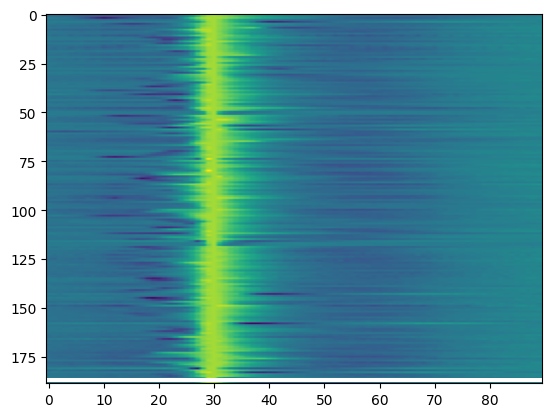

In [6]:
plt.imshow(all_wfs_nl, aspect='auto', cmap='viridis')

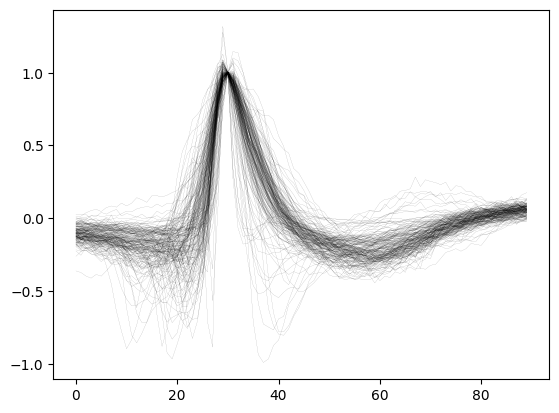

In [7]:
plt.plot(all_wfs_nl.T, alpha=1, linewidth=0.05, color='k');
plt.show()

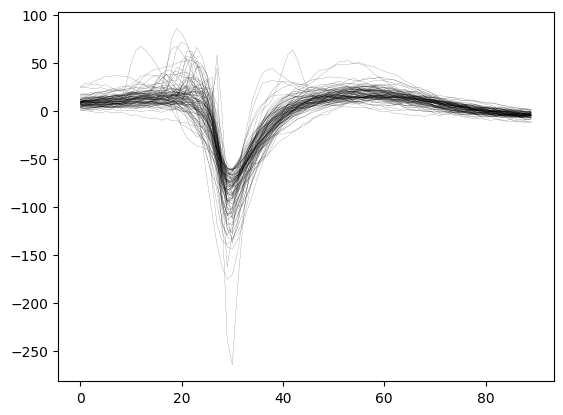

In [8]:
plt.plot((np.array(all_wfs)[np.array(all_peaks)<-60]).T, alpha=1, linewidth=0.1, color='k');
plt.show()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  5.,  7., 12., 18., 31.,
        48., 44.,  8.,  0.,  0.,  0.,  0.,  3.,  1.,  0.,  3.,  0.,  2.,
         1.,  1.,  0.,  2.]),
 array([-264.54745483, -249.55157064, -234.55568644, -219.55980225,
        -204.56391805, -189.56803385, -174.57214966, -159.57626546,
        -144.58038127, -129.58449707, -114.58861287,  -99.59272868,
         -84.59684448,  -69.60096029,  -54.60507609,  -39.60919189,
         -24.6133077 ,   -9.6174235 ,    5.37846069,   20.37434489,
          35.37022909,   50.36611328,   65.36199748,   80.35788167,
          95.35376587,  110.34965007,  125.34553426,  140.34141846,
         155.33730265,  170.33318685,  185.32907104]),
 <BarContainer object of 30 artists>)

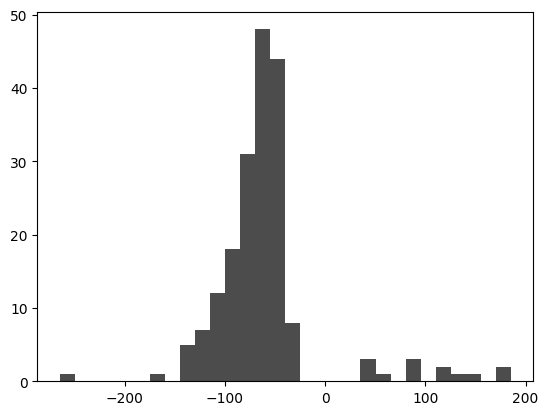

In [63]:
plt.hist(x=np.array(all_peaks), bins=30, color='k', alpha=0.7)

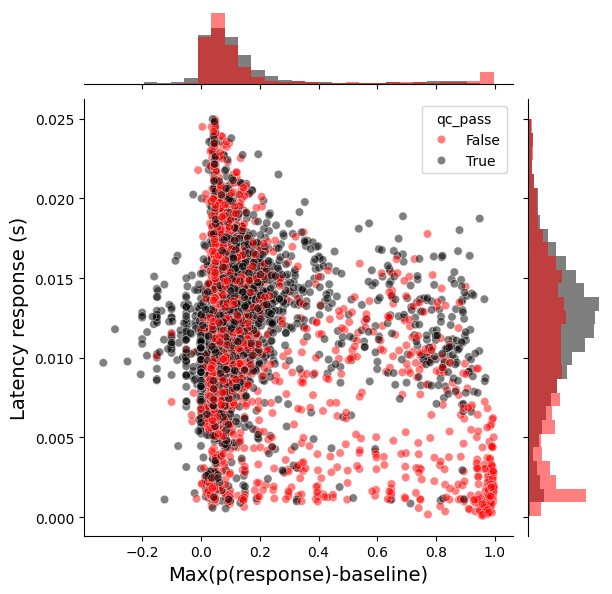

In [9]:
# Define color palette for groups
palette = {True: "k", False: "red"}

# Create JointGrid
g = sns.JointGrid(data=combined_tagged_units, x='p_max', y='lat_max_p', hue='qc_pass', palette=palette)

# Add scatter plot in the center
g.plot_joint(sns.scatterplot, alpha=0.5)
g.ax_joint.set_xlabel('Max(p(response)-baseline)', fontsize=14)
g.ax_joint.set_ylabel('Latency response (s)', fontsize=14)

# Add histograms manually for each group
p_max_bins = np.linspace(combined_tagged_units['p_max'].min(), combined_tagged_units['p_max'].max(), 30)
lat_max_p_bins = np.linspace(combined_tagged_units['lat_max_p'].min(), combined_tagged_units['lat_max_p'].max(), 30)
for qc_val, color in palette.items():
    subset = combined_tagged_units[combined_tagged_units['qc_pass'] == qc_val]
    
    # Horizontal histogram for x-axis (default orientation)
    sns.histplot(subset['p_max'], ax=g.ax_marg_x, bins=p_max_bins, color=color, alpha=0.5, edgecolor='none')

    # **VERTICAL histogram for y-axis** using orientation="horizontal"
    sns.histplot(y=subset['lat_max_p'], ax=g.ax_marg_y, bins=lat_max_p_bins, color=color, alpha=0.5, edgecolor='none')


# Show plot
plt.show()


In [10]:
# pca for waveform
from sklearn.decomposition import PCA
from scipy.stats import zscore
# Perform PCA on the waveforms
amp_thresh = -75
wf_mat = zscore(all_wfs_nl[np.array(all_peaks)<amp_thresh], axis=0, nan_policy='omit')  # z-score normalize the waveforms
wf_mat = np.delete(wf_mat, 30, axis=1)
# plt.imshow(wf_mat, aspect='auto', cmap='viridis')
# plt.colorbar(label='Normalized Amplitude')

/tmp/ipykernel_15450/1698409633.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  wf_mat = zscore(all_wfs_nl[np.array(all_peaks)<amp_thresh], axis=0, nan_policy='omit')  # z-score normalize the waveforms


Explained variance ratios: [0.40328961 0.24938614 0.13438593 0.05556902 0.04464938]


Text(0.5, 1.0, 'Explained Variance by PCA Components')

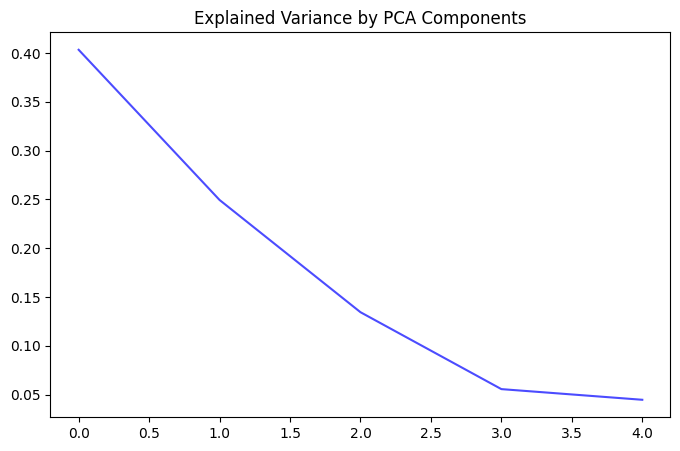

In [11]:
# perform PCA
pca = PCA(n_components=5)  # we can choose the number of components we want
pca_result = pca.fit_transform(wf_mat)
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance ratios: {explained_variance}')
# Plot the explained variance
plt.figure(figsize=(8, 5))
plt.plot(explained_variance, alpha=0.7, color='blue')
plt.title('Explained Variance by PCA Components')

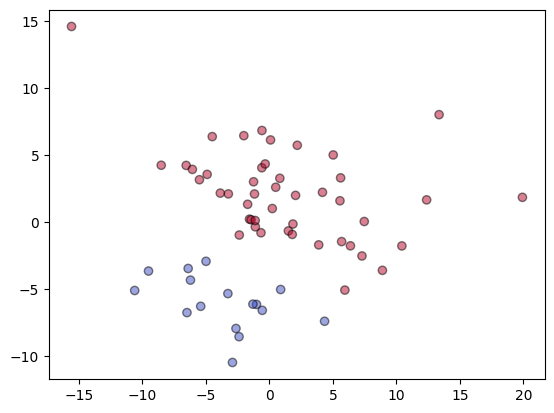

In [12]:
filter = (pca_result[:, 0] + 1.5 * pca_result[:, 1]) > -5
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, c = filter, cmap='coolwarm', edgecolor='k')

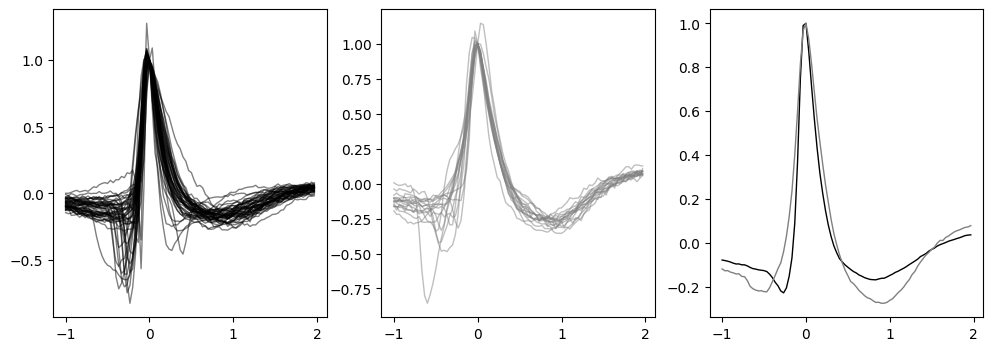

In [13]:
fig = plt.figure(figsize=(12, 4))
wf_time = (np.arange(90) - 30)/30000 * 1000  # assuming 90 samples in the waveform
plt.subplot(1, 3, 1)
plt.plot(wf_time, all_wfs_nl[np.array(all_peaks)<amp_thresh][filter].T, alpha=0.5, linewidth=1, color='k');
plt.subplot(1, 3, 2)
plt.plot(wf_time, all_wfs_nl[np.array(all_peaks)<amp_thresh][~filter].T, alpha=0.5, linewidth=1, color=[0.5, 0.5, 0.5]);  # plot the ones with higher pca values in black
plt.subplot(1, 3, 3)
plt.plot(wf_time, np.mean(all_wfs_nl[np.array(all_peaks)<amp_thresh][filter], axis=0), linewidth=1, color='k');  # plot the ones with higher pca values in black
plt.plot(wf_time, np.mean(all_wfs_nl[np.array(all_peaks)<amp_thresh][~filter], axis=0), linewidth=1, color=[0.5, 0.5, 0.5]);

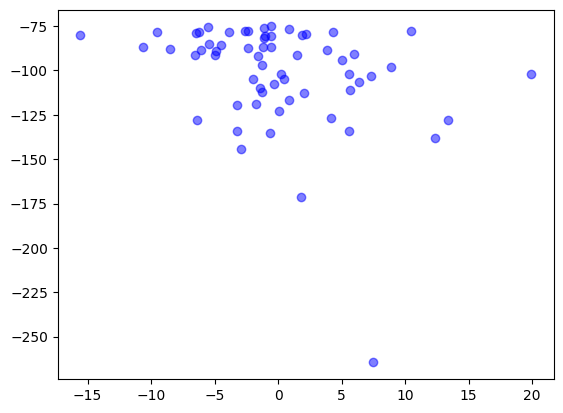

In [14]:
plt.scatter(pca_result[:, 0], np.array(all_peaks)[np.array(all_peaks)<amp_thresh], alpha=0.5, color='blue')

In [60]:
# get all t-stats, coeffs, p-values for the two groups
# grab all tagged units and combine spike waveforms
data_type = 'curated'
target = 'soma'
all_coefs = []
all_T = []
all_p = []
align_name = 'response'
formula = 'spikes ~ 1 + outcome + choice + Qchosen'
curr_session = None
pre_event = -1.5
post_event = 3
model_name = 'stan_qLearning_5params'
binSize = 1.5
for session, unit_id, tag, qc in zip(all_sessions, all_units, all_tagged_units, all_qc_pass_units):
    if tag and qc: 
        curr_coefs = np.full(3, np.nan)  # initialize with NaN
        curr_T = np.full(3, np.nan)
        curr_p = np.full(3, np.nan)
        # check if different session
        if curr_session is None or curr_session != session:
            session_dir = session_dirs(session)
            unit_tbl = get_unit_tbl(session, data_type)
            session_df = makeSessionDF(session, model_name = model_name)
            curr_session = session
        unit_drift = load_drift(session, unit_id, data_type=data_type)
        spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
        session_df_curr = session_df.copy()
        spike_times_curr = spike_times.copy()
        # tblTrials_curr = tblTrials.copy()
        if unit_drift is not None:
            if unit_drift['ephys_cut'][0] is not None:
                spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
                session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= unit_drift['ephys_cut'][0]]
                # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
            if unit_drift['ephys_cut'][1] is not None:
                spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
                session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= unit_drift['ephys_cut'][1]]
                # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]

            if align_name == 'go_cue':
                align_time = session_df_curr['go_cue_time'].values
                # align_time_all = tblTrials_curr['goCue_start_time'].values
            elif align_name == 'response':
                align_time = session_df_curr['choice_time'].values
                # align_time_all = tblTrials_curr['reward_outcome_time'].values
            # spike_matrix, slide_times = get_spike_matrix(spike_times_curr, align_time, 
            #                                             pre_event=pre_event, post_event=post_event, 
            #                                             binSize=binSize, stepSize=stepSize)
            spike_matrix_LM, slide_times_LM = get_spike_matrix(spike_times_curr, align_time, 
                                                        pre_event=pre_event, post_event=post_event, 
                                                        binSize=binSize, stepSize=0.25)
            # spike_matrix_all, slide_times = get_spike_matrix(spike_times_curr, align_time_all, 
            #                                             pre_event=pre_event, post_event=post_event, 
            #                                             binSize=binSize, stepSize=stepSize)
            spike_matrix_LM = zscore(spike_matrix_LM, axis=0)  
            try:
                regressors, curr_T, curr_p, curr_coefs = fitSpikeModelG(session_df_curr, spike_matrix_LM, formula)
            except:
                regressors, curr_T, curr_p, curr_coefs = [None]*4
        all_coefs.append(curr_coefs)
        all_T.append(curr_T)
        all_p.append(curr_p)


In [61]:
valid_shape = next((coef.shape for coef in all_coefs if coef is not None), None)
if valid_shape:
    # Replace None with a zero matrix (or another default value)
    all_coefs = [coef if coef is not None else np.full(valid_shape, np.nan) for coef in all_coefs]
    all_T = [T if T is not None else np.full(valid_shape, np.nan) for T in all_T]
    all_p = [p if p is not None else np.full(valid_shape, np.nan) for p in all_p]
all_coefsm = np.array(all_coefs)
all_Tm = np.array(all_T)
all_pm = np.array(all_p)

int_ind = (np.array(regressors) == 'Intercept') | (np.array(regressors) == 'intercept')  # find the index of the intercept
regressors = np.array(regressors)[~int_ind]  # exclude intercept from the regressors
all_coefs = all_coefsm[:, :, ~int_ind]  # exclude intercept from the coefficients
all_Tm = all_Tm[:, :, ~int_ind]  # exclude intercept from the T-statistics
all_pm = all_pm[:, :, ~int_ind]  # exclude intercept from the p-values

Text(0.5, 0.98, 'T-statistics for all regressors')

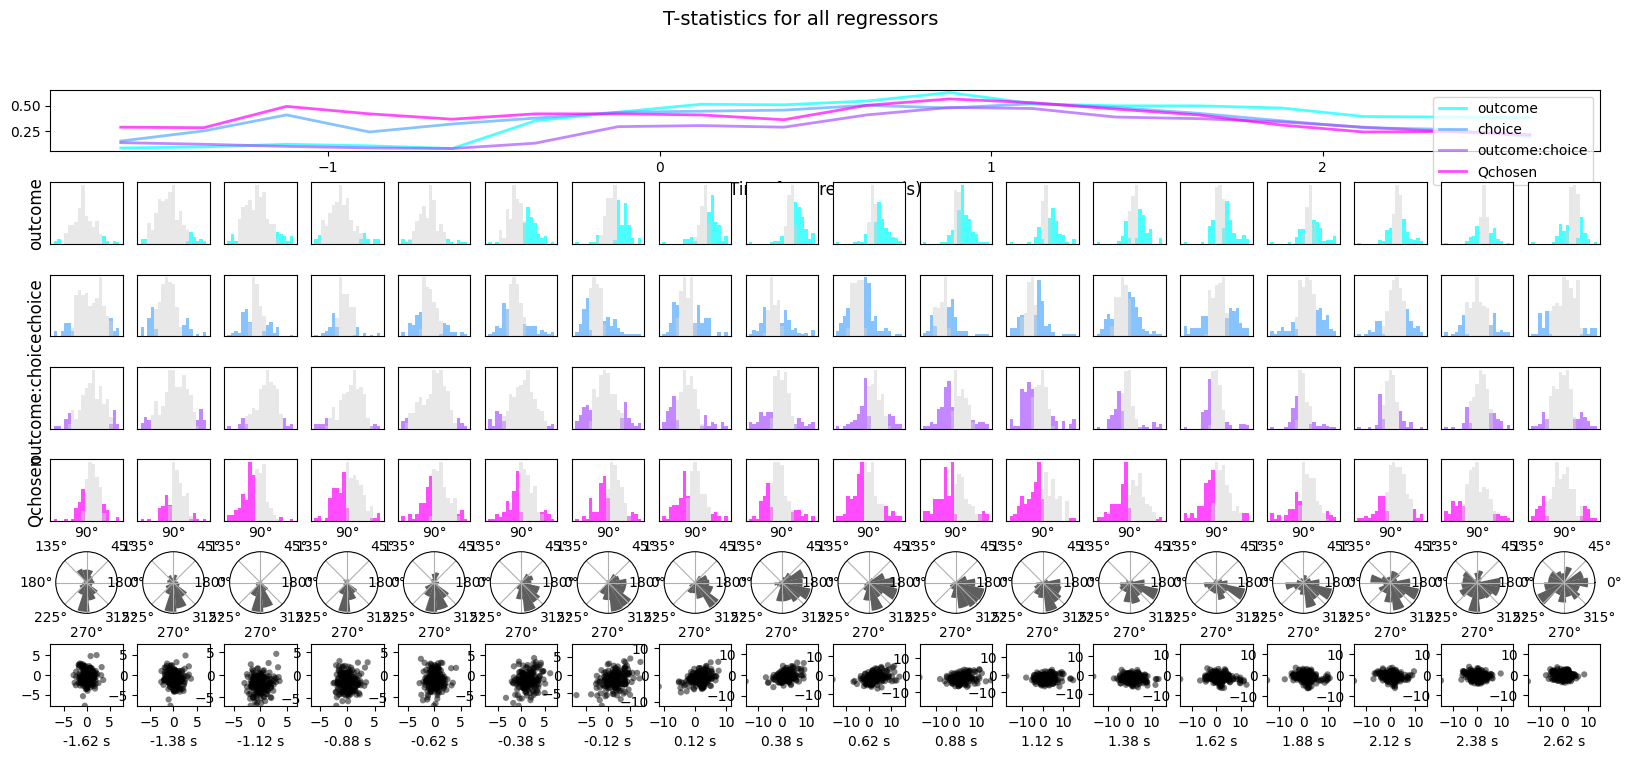

In [59]:
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(len(regressors)+3, len(slide_times_LM), figure=fig, hspace=0.5)
cmap = plt.cm.cool  # Get the colormap
colors = cmap(np.linspace(0, 1, len(regressors)))
ax_all = fig.add_subplot(gs[0, :]) 
for reg_ind, regressor in enumerate(regressors):
    for time_ind, time in enumerate(slide_times_LM):
        ax = fig.add_subplot(gs[reg_ind+1, time_ind])
        curr_Ts = all_Tm[:, time_ind, reg_ind]  # get the T-statistics for the current regressor and time
        curr_Ps = all_pm[:, time_ind, reg_ind]  # get the p-values for the current regressor and time
        bins = np.linspace(np.nanmin(curr_Ts)-0.01, np.nanmax(curr_Ts)+0.01, 20)
        ax.hist(curr_Ts[curr_Ps<0.05], bins=bins, color=colors[reg_ind], alpha=0.7, edgecolor='none')  # plot T-statistics with p<0.05
        ax.hist(curr_Ts[curr_Ps>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
        if time_ind == 0:
            ax.set_ylabel(f'{regressor}', fontsize=12)
        # turn off y-ticks and x-ticks
        ax.set_yticks([])
        ax.set_xticks([])

    curr_Ps = np.squeeze(all_pm[:, :, reg_ind])
    # check if any p-values are below 0.05
    curr_Ps_sig = np.nanmean(curr_Ps < 0.05, axis = 0)    
    ax_all.plot(slide_times_LM, curr_Ps_sig, color=colors[reg_ind], alpha=0.7, linewidth=2, label=regressor)  # plot the proportion of significant p-values over time
    ax_all.legend(loc='upper right', fontsize=10)
    ax_all.set_xlabel(f'Time from {align_name} (s)', fontsize=12)

reward_ind = np.where(np.array(regressors) == 'outcome')[0][0]  # find the index of the reward outcome
q_ind = np.where(np.array(regressors) == 'Qchosen')[0][0]  # find the index of the Qchosen
for time_ind, time in enumerate(slide_times_LM):
    ax = fig.add_subplot(gs[-1, time_ind])
    curr_T_reward = all_Tm[:, time_ind, reward_ind]  # get the T-statistics for the reward outcome
    curr_T_q = all_Tm[:, time_ind, q_ind]  # get the T-statistics for the Qchosen
    curr_coefs_reward = all_coefs[:, time_ind, reward_ind]  # get the coefficients for the reward outcome
    curr_coefs_q = all_coefs[:, time_ind, q_ind]  # get the coefficients for the Qchosen
    ax.scatter(curr_T_reward, curr_T_q, alpha=0.5, color='k', edgecolors='none', s=20)
    ax.set_xlabel(f'{time:.2f} s')
    limit = np.max([np.nanmax(np.abs(curr_T_reward)), np.nanmax(np.abs(curr_T_q))])
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)

    # polar
    all_vec = np.column_stack((curr_coefs_reward, curr_coefs_q))  # combine the coefficients for the reward outcome and Qchosen]))

    # Convert Cartesian coordinates to polar coordinates
    theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])

    # Define histogram edges (bins) from -π to π
    edges = np.linspace(-np.pi, np.pi, 4*4)

    # Create polar histogram
    ax = fig.add_subplot(gs[-2, time_ind], polar=True)
    ax.hist(theta, bins=edges, color=[0.1, 0.1, 0.1], alpha=0.7, edgecolor='none', density=True)
    ax.set_yticks([])

plt.suptitle('T-statistics for all regressors', fontsize=14)


Text(0.5, 0.98, 'T-statistics for all regressors')

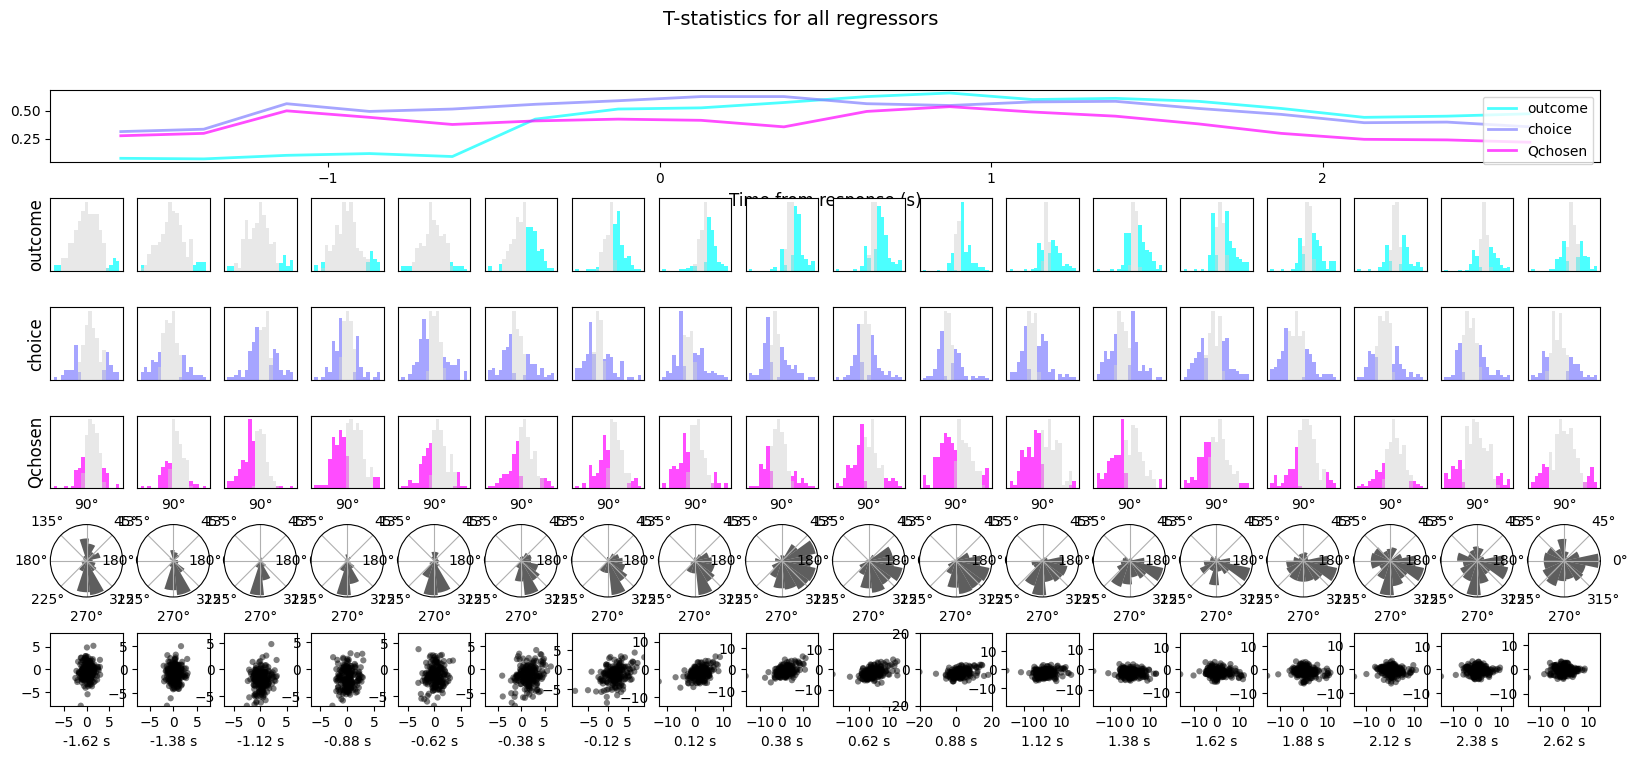

In [62]:
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(len(regressors)+3, len(slide_times_LM), figure=fig, hspace=0.5)
cmap = plt.cm.cool  # Get the colormap
colors = cmap(np.linspace(0, 1, len(regressors)))
ax_all = fig.add_subplot(gs[0, :]) 
for reg_ind, regressor in enumerate(regressors):
    for time_ind, time in enumerate(slide_times_LM):
        ax = fig.add_subplot(gs[reg_ind+1, time_ind])
        curr_Ts = all_Tm[:, time_ind, reg_ind]  # get the T-statistics for the current regressor and time
        curr_Ps = all_pm[:, time_ind, reg_ind]  # get the p-values for the current regressor and time
        bins = np.linspace(np.nanmin(curr_Ts)-0.01, np.nanmax(curr_Ts)+0.01, 20)
        ax.hist(curr_Ts[curr_Ps<0.05], bins=bins, color=colors[reg_ind], alpha=0.7, edgecolor='none')  # plot T-statistics with p<0.05
        ax.hist(curr_Ts[curr_Ps>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
        if time_ind == 0:
            ax.set_ylabel(f'{regressor}', fontsize=12)
        # turn off y-ticks and x-ticks
        ax.set_yticks([])
        ax.set_xticks([])

    curr_Ps = np.squeeze(all_pm[:, :, reg_ind])
    # check if any p-values are below 0.05
    curr_Ps_sig = np.nanmean(curr_Ps < 0.05, axis = 0)    
    ax_all.plot(slide_times_LM, curr_Ps_sig, color=colors[reg_ind], alpha=0.7, linewidth=2, label=regressor)  # plot the proportion of significant p-values over time
    ax_all.legend(loc='upper right', fontsize=10)
    ax_all.set_xlabel(f'Time from {align_name} (s)', fontsize=12)

reward_ind = np.where(np.array(regressors) == 'outcome')[0][0]  # find the index of the reward outcome
q_ind = np.where(np.array(regressors) == 'Qchosen')[0][0]  # find the index of the Qchosen
for time_ind, time in enumerate(slide_times_LM):
    ax = fig.add_subplot(gs[-1, time_ind])
    curr_T_reward = all_Tm[:, time_ind, reward_ind]  # get the T-statistics for the reward outcome
    curr_T_q = all_Tm[:, time_ind, q_ind]  # get the T-statistics for the Qchosen
    curr_coefs_reward = all_coefs[:, time_ind, reward_ind]  # get the coefficients for the reward outcome
    curr_coefs_q = all_coefs[:, time_ind, q_ind]  # get the coefficients for the Qchosen
    ax.scatter(curr_T_reward, curr_T_q, alpha=0.5, color='k', edgecolors='none', s=20)
    ax.set_xlabel(f'{time:.2f} s')
    limit = np.max([np.nanmax(np.abs(curr_T_reward)), np.nanmax(np.abs(curr_T_q))])
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)

    # polar
    all_vec = np.column_stack((curr_coefs_reward, curr_coefs_q))  # combine the coefficients for the reward outcome and Qchosen]))

    # Convert Cartesian coordinates to polar coordinates
    theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])

    # Define histogram edges (bins) from -π to π
    edges = np.linspace(-np.pi, np.pi, 4*4)

    # Create polar histogram
    ax = fig.add_subplot(gs[-2, time_ind], polar=True)
    ax.hist(theta, bins=edges, color=[0.1, 0.1, 0.1], alpha=0.7, edgecolor='none', density=True)
    ax.set_yticks([])

plt.suptitle('T-statistics for all regressors', fontsize=14)
